# Persistence
Here we are attempting to time travel persistence in our workflow

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver                           # This is the tool that we will use to save the state temporarily in the memory as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict

This is for graphing purpose

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
llm = ChatOllama(model="llama3.1:8b")

## 3. Create a state

In [4]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 4. Define the function for the graph node

In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [6]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

## 5. Create the graph

In [7]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

### Incorporate the checkpointer

In [8]:
checkpointer = InMemorySaver()

## 6. Compile the graph while incorporating the checkpointer

In [9]:
workflow = graph.compile(checkpointer=checkpointer)

## 7. The Graph

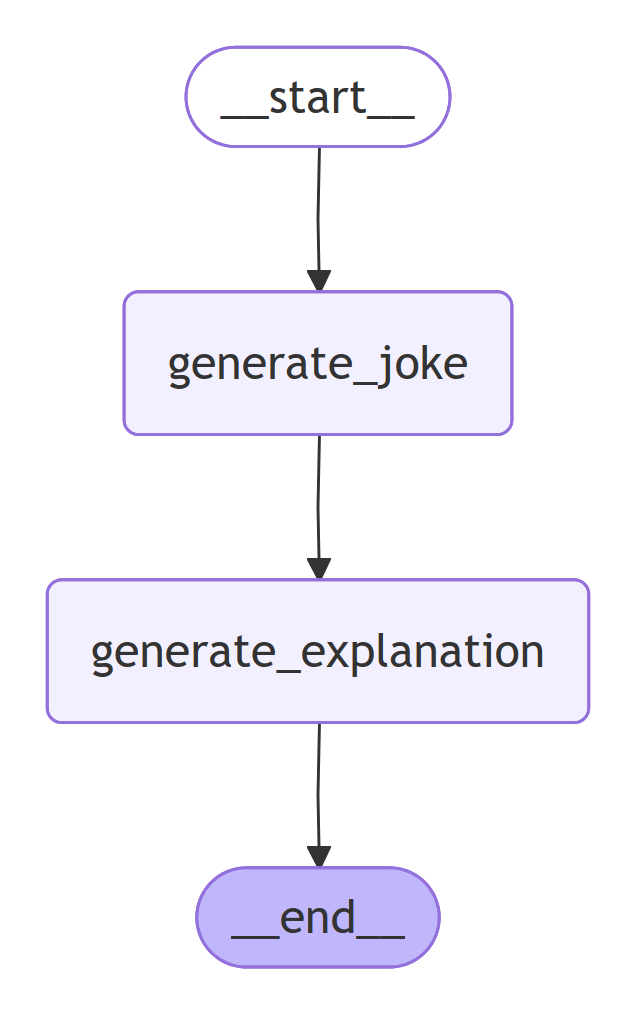

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 8. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [11]:
config1 = {"configurable": {"thread_id": "1"}}

## 9. Run the code

In [12]:
# First Thread
final_state = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state)

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty! (get it?)", 'explanation': 'The joke relies on wordplay to create a pun. "Crusty" has a double meaning here: \n\n*   The crust is the outer layer of a bread, like a slice of pizza.\n*   A person can be described as being in a bad mood and feeling irritable as "crusty".\n\nThe joke uses this double meaning to create a pun, where the phrase "feeling a little crusty" has two different interpretations: one literal (the pizza\'s outer layer), and one figurative (a person who is feeling grumpy). The punchline relies on the listener being familiar with the wordplay and understanding both meanings of the word "crusty".'}


In [13]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty! (get it?)", 'explanation': 'The joke relies on wordplay to create a pun. "Crusty" has a double meaning here: \n\n*   The crust is the outer layer of a bread, like a slice of pizza.\n*   A person can be described as being in a bad mood and feeling irritable as "crusty".\n\nThe joke uses this double meaning to create a pun, where the phrase "feeling a little crusty" has two different interpretations: one literal (the pizza\'s outer layer), and one figurative (a person who is feeling grumpy). The punchline relies on the listener being familiar with the wordplay and understanding both meanings of the word "crusty".'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b317b-52a7-6f3f-8002-7ec774e224bb'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-27T09:31:25.356617+00:00', pare

# 10. Checking the checkpoint status

In [14]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty! (get it?)", 'explanation': 'The joke relies on wordplay to create a pun. "Crusty" has a double meaning here: \n\n*   The crust is the outer layer of a bread, like a slice of pizza.\n*   A person can be described as being in a bad mood and feeling irritable as "crusty".\n\nThe joke uses this double meaning to create a pun, where the phrase "feeling a little crusty" has two different interpretations: one literal (the pizza\'s outer layer), and one figurative (a person who is feeling grumpy). The punchline relies on the listener being familiar with the wordplay and understanding both meanings of the word "crusty".'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b317b-52a7-6f3f-8002-7ec774e224bb'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-27T09:31:25.356617+00:00', par

# 11. Recalling the workflow using the checkpoint

### Review the state

In [18]:
config2 = {"configurable": {"thread_id": "1", "checkpoint_id": "1f0b317a-748b-6d61-8000-fafa7dc2531c"}}
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0b317a-748b-6d61-8000-fafa7dc2531c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T09:31:02.066714+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b317a-7489-68ec-bfff-6a5149207e54'}}, tasks=(PregelTask(id='02acc8ca-053d-7fe8-560a-bf805b8b48b4', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling a little crusty! (get it?)"}),), interrupts=())

### Invoke the workflow on the checkpoint

In [19]:
final_state = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state)

{'topic': 'pizza', 'joke': 'Why did the pizza go to therapy?\n\nBecause it was feeling crusty.', 'explanation': 'A classic play on words!\n\nThe joke is a pun, which relies on wordplay to create humor. Here\'s how it works:\n\n* The setup of the joke ("Why did the pizza go to therapy?") primes the listener to expect a reason related to emotional or psychological issues, typical of why someone might attend therapy.\n* But instead of providing a serious explanation, the punchline subverts this expectation by making a wordplay on "crusty", which has multiple meanings:\n\t+ A crust is a characteristic feature of pizza, referring to its outer layer of dough.\n\t+ However, "feeling crusty" can also be an idiom that means feeling grumpy or irritable.\n\nSo, the joke relies on this double meaning of "crusty" to create a clever and amusing connection between the setup and the punchline. It\'s a lighthearted way to poke fun at the idea of pizzas needing therapy (which is already a silly concept)

# 12. Checking the checkpoint status again

In [20]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to therapy?\n\nBecause it was feeling crusty.', 'explanation': 'A classic play on words!\n\nThe joke is a pun, which relies on wordplay to create humor. Here\'s how it works:\n\n* The setup of the joke ("Why did the pizza go to therapy?") primes the listener to expect a reason related to emotional or psychological issues, typical of why someone might attend therapy.\n* But instead of providing a serious explanation, the punchline subverts this expectation by making a wordplay on "crusty", which has multiple meanings:\n\t+ A crust is a characteristic feature of pizza, referring to its outer layer of dough.\n\t+ However, "feeling crusty" can also be an idiom that means feeling grumpy or irritable.\n\nSo, the joke relies on this double meaning of "crusty" to create a clever and amusing connection between the setup and the punchline. It\'s a lighthearted way to poke fun at the idea of pizzas needing therapy (which is al